In [103]:
# Цель данного проекта - подойти к проблеме фильтрации миллионов товаров в каталогах со стороны машинного обучения.
# По сути, мы находим веса признаков-фильтров на определённом наборе данных, чтобы выдавать эти фильтры пользователю
# в определённой послежлвательности, не опираясь на логику или семантику, а используя
# вероятностные методы...лучше назвать их так. Приоритет весов что ли. 
# Применение можно найти абсолютно разное, чередуя кластеризацию и классификацию. Заранее просчитать цепочки навигации,
# в виде деревьев с множеством ветвей. Делать это 'по ходу пьесы', если позволяет вычислительная мощность. Снижать
# кол=во товаров в выборке за счёт кластеризаций после каждой итерации. 
# Основной подводный камень: всё это лишь ВЕРОЯТНОСТИ. Всегда есть шанс не получить то, что требуется.
# Также сложность в обёртке всего этого в микросервис. В быстродействии, если модели не предобучены, и всё проиходит на ходу.

#грузим датасет
import pandas as pd
dataframe = pd.read_csv('C://Users/Uldum/Downloads/data.csv', low_memory = False)

In [104]:
# смотрим поверхностно на данные. Видим разные типы данных + множество пропущенных значений.
dataframe.head(5)

,id,class,c1,c2,c3,c4,c5,c6,c7,c8,...,c53,c54,c55,c56,c57,c58,c59,c60,created_at,updated_at
0,1,545988074,0,0,0,правое,NaN,NaN,NaN,NaN,...,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,545988074,0,0,0,правое,NaN,NaN,NaN,NaN,...,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,647859449,1014559500,33652,-1898910370,левое,9,50.0,14,953176870.0,...,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,647859449,1017330063,33655,-645229505,левое,Не предъявляется,50.0,14,-699300431.0,...,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,647859449,1482170768,1017353208,-826554069,левое,Не предъявляется,50.0,14,953176870.0,...,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [105]:
# просто смотрю значения в колонках. Лучше бы сразу строил боксплоты и обрезал выбросы циклом

dataframe['class'].value_counts()

545988074    15362
647859449       41
Name: class, dtype: int64

In [8]:
dataframe['c2'].value_counts()

1040736       15360
33655            24
33652             6
1017353208        6
1044374           5
0                 2
Name: c2, dtype: int64

In [9]:
dataframe['c3'].value_counts()

 0             15362
-645229505        24
-1898910370        6
-826554069         6
 634662849         5
Name: c3, dtype: int64

In [10]:
dataframe['c8'].value_counts()

 0.000000e+00    15360
-6.993004e+08       24
 9.531769e+08       12
 1.756160e+09        5
Name: c8, dtype: int64

In [11]:
dataframe['c9'].value_counts()

0             15362
438320836        24
1175637482        6
1204266630        6
466949963         5
Name: c9, dtype: int64

In [12]:
dataframe['c46'].value_counts()

30.0    15360
12.0       24
16.0       17
Name: c46, dtype: int64

In [13]:
dataframe['c48'].value_counts()

1.0    15400
3.0        1
Name: c48, dtype: int64

In [14]:
# продолжаем оценку данных. Колонок типа object - категориальных, довольно много. Есть колонка с id, нулевые колонки
dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15403 entries, 0 to 15402
Data columns (total 64 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   id          15403 non-null  int64  
 1   class       15403 non-null  int64  
 2   c1          15403 non-null  int64  
 3   c2          15403 non-null  int64  
 4   c3          15403 non-null  int64  
 5   c4          15403 non-null  object 
 6   c5          15401 non-null  object 
 7   c6          15401 non-null  float64
 8   c7          41 non-null     object 
 9   c8          15401 non-null  float64
 10  c9          15403 non-null  int64  
 11  c10         0 non-null      float64
 12  c11         0 non-null      float64
 13  c12         768 non-null    object 
 14  c13         0 non-null      float64
 15  c14         15401 non-null  object 
 16  c15         7683 non-null   object 
 17  c16         0 non-null      float64
 18  c17         15401 non-null  object 
 19  c18         15401 non-nul

In [106]:
#сбрасываем колонку с id
dataframe = dataframe.drop(['id'], axis=1)

In [107]:
# сбрасываем дубликаты строк
dataframe = dataframe.drop_duplicates()

In [17]:
# так как колонок с категориальными значениями много, то выберем парочку для обработки. Остальное отбросим. Нет смысла ради
# тестового задания терять столько времени. На оставшиеся данные применим алгоритм кластеризации.
# смотрим какие значения и сколько содержатся в колонке c4
dataframe['c4'].value_counts()

левое     15396
правое        6
Name: c4, dtype: int64

In [18]:
# смотрим на колонку c47. Заполнена одним и тем же значением. Бессмысленно. Уберём.
dataframe['c47'].value_counts()

16.0    15401
Name: c47, dtype: int64

In [19]:
# c43 туда же.
dataframe['c43'].value_counts()

18    15402
Name: c43, dtype: int64

In [108]:
# преобразуем колонку с категориальными значениями в нумерик. Используем встроенный метод библиотеки sckitlearn
from sklearn.preprocessing import OneHotEncoder
# создаём экземпляр класса энкодера
oe_style = OneHotEncoder()

In [109]:
# заполняем нужной колонкой переменную с энкодером, выводим массив значений 0 и 1 - левое и правое.
oe_results = oe_style.fit_transform(dataframe[["c4"]])
oe_results.toarray()

array([[0., 1.],
       [1., 0.],
       [1., 0.],
       ...,
       [1., 0.],
       [1., 0.],
       [1., 0.]])

In [110]:
# из массива получим датафрейм с колонками Left и right
pd.DataFrame(oe_results.toarray(), columns=['C4_l', 'c4_r']).head()

,C4_l,c4_r
0,0.0,1.0
1,1.0,0.0
2,1.0,0.0
3,1.0,0.0
4,0.0,1.0


In [111]:
# соединим полученный датафрейм с исходным датафреймом с помощью join. Выведем первые строки нового дф.
obj_df = dataframe.join(pd.DataFrame(oe_results.toarray(), columns=['C4_l', 'c4_r']))
obj_df.head()

,class,c1,c2,c3,c4,c5,c6,c7,c8,c9,...,c55,c56,c57,c58,c59,c60,created_at,updated_at,C4_l,c4_r
0,545988074,0,0,0,правое,NaN,NaN,NaN,NaN,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1.0
2,647859449,1014559500,33652,-1898910370,левое,9,50.0,14,9.531769e+08,1175637482,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0
3,647859449,1017330063,33655,-645229505,левое,Не предъявляется,50.0,14,-6.993004e+08,438320836,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0
4,647859449,1482170768,1017353208,-826554069,левое,Не предъявляется,50.0,14,9.531769e+08,1204266630,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1.0
5,647859449,-1568968858,1044374,634662849,правое,Не предъявляется,250.0,2242,1.756160e+09,466949963,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0


In [112]:
# сбросим категориальную колонку, которую преобразовали в числовые значения.
obj_df = obj_df.drop(['class', 'c4', 'C4_l', 'c4_r'], axis=1)
obj_df.head()

,c1,c2,c3,c5,c6,c7,c8,c9,c10,c11,...,c53,c54,c55,c56,c57,c58,c59,c60,created_at,updated_at
0,0,0,0,NaN,NaN,NaN,NaN,0,NaN,NaN,...,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1014559500,33652,-1898910370,9,50.0,14,9.531769e+08,1175637482,NaN,NaN,...,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1017330063,33655,-645229505,Не предъявляется,50.0,14,-6.993004e+08,438320836,NaN,NaN,...,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1482170768,1017353208,-826554069,Не предъявляется,50.0,14,9.531769e+08,1204266630,NaN,NaN,...,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,-1568968858,1044374,634662849,Не предъявляется,250.0,2242,1.756160e+09,466949963,NaN,NaN,...,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [25]:
# теперь взглянем на колонку c5. Не понятно, что это за значения. Но скорее всего какой-то ряд константных уровней, от 0 -
# Не предъявляется, до 100. Нужно перевести всё в числовую форму и заменить на 0 Не предъявляется.
obj_df['c5'].value_counts()

100                 7680
30                  6912
50                   768
Не предъявляется      35
9                      6
Name: c5, dtype: int64

In [ ]:
# Сначала посмотрим незаполненные значения в колонке. Видим 1 строку.

In [113]:
obj_df['c5'].isnull().sum()

1

In [114]:
# заполним эту строку наиболее часто встречающимся значением в колонке. В этом случае - 100.
obj_df['c5'] = obj_df['c5'].fillna(obj_df['c5'].value_counts().index[0])
obj_df.head()

,c1,c2,c3,c5,c6,c7,c8,c9,c10,c11,...,c53,c54,c55,c56,c57,c58,c59,c60,created_at,updated_at
0,0,0,0,100,NaN,NaN,NaN,0,NaN,NaN,...,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1014559500,33652,-1898910370,9,50.0,14,9.531769e+08,1175637482,NaN,NaN,...,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1017330063,33655,-645229505,Не предъявляется,50.0,14,-6.993004e+08,438320836,NaN,NaN,...,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1482170768,1017353208,-826554069,Не предъявляется,50.0,14,9.531769e+08,1204266630,NaN,NaN,...,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,-1568968858,1044374,634662849,Не предъявляется,250.0,2242,1.756160e+09,466949963,NaN,NaN,...,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [115]:
# теперь напишем примитивную функцию, которая будет принимать на входе текст,пытаться применить к нему числовой тип данных,
# а если потерпит неудачу, то возвратит 0. Так если мы встретим числа в формате строки, то они приобразуются в числа, 
# а если строку Не предъявляется, то заменим её на 0.
def cat_to_num(text):
  try:  
    return int(text)
  except:
    return 0

# применяем функцию к колонке методом apply. Смотрим значения в колонке.
obj_df['c5'] = obj_df['c5'].apply(cat_to_num)
obj_df['c5'].value_counts()

100    7681
30     6912
50      768
0        35
9         6
Name: c5, dtype: int64

In [29]:
# выведем инфу, посмотреть какие колонки ушли, какие появились, какие изменили тип
obj_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15402 entries, 0 to 15402
Data columns (total 64 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   class       15402 non-null  int64  
 1   c1          15402 non-null  int64  
 2   c2          15402 non-null  int64  
 3   c3          15402 non-null  int64  
 4   c5          15402 non-null  int64  
 5   c6          15401 non-null  float64
 6   c7          41 non-null     object 
 7   c8          15401 non-null  float64
 8   c9          15402 non-null  int64  
 9   c10         0 non-null      float64
 10  c11         0 non-null      float64
 11  c12         768 non-null    object 
 12  c13         0 non-null      float64
 13  c14         15401 non-null  object 
 14  c15         7683 non-null   object 
 15  c16         0 non-null      float64
 16  c17         15401 non-null  object 
 17  c18         15401 non-null  object 
 18  c19         0 non-null      float64
 19  c20         15401 non-nul

In [116]:
# На этом этапе я решил избавится от колонок типа object, которые не собираюсь преобразовывать.  Применим метод 
# select-exclude
# также сразу дропнем колонки с43, с47, в которых ранее обнаружили одинаковые значения
df = obj_df.select_dtypes(exclude=['object'])
df = df.drop(['c43', 'c47'], axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15402 entries, 0 to 15402
Data columns (total 45 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   c1          15402 non-null  int64  
 1   c2          15402 non-null  int64  
 2   c3          15402 non-null  int64  
 3   c5          15402 non-null  int64  
 4   c6          15401 non-null  float64
 5   c8          15401 non-null  float64
 6   c9          15402 non-null  int64  
 7   c10         0 non-null      float64
 8   c11         0 non-null      float64
 9   c13         0 non-null      float64
 10  c16         0 non-null      float64
 11  c19         0 non-null      float64
 12  c21         0 non-null      float64
 13  c22         15401 non-null  float64
 14  c23         15402 non-null  float64
 15  c24         0 non-null      float64
 16  c25         0 non-null      float64
 17  c26         5 non-null      float64
 18  c28         5 non-null      float64
 19  c29         0 non-null   

In [117]:
# посмотрим на пропущенные значения по всем колокам. Довольно много колонок состоит только из них.
df.isna().sum()

c1                0
c2                0
c3                0
c5                0
c6                1
c8                1
c9                0
c10           15402
c11           15402
c13           15402
c16           15402
c19           15402
c21           15402
c22               1
c23               0
c24           15402
c25           15402
c26           15397
c28           15397
c29           15402
c30           15402
c31           15402
c32               2
c33           15402
c34           15402
c35           15402
c36           15393
c37           15402
c38           15402
c39           15402
c40               1
c41           15393
c42           15402
c44           15402
c45           15402
c46               1
c48               1
c49           15360
c50           15384
c51           15391
c52           15402
c53           15402
c54               0
created_at    15402
updated_at    15402
dtype: int64

In [118]:
# уберём сначала строки axis=0 с хотя бы 1 незаполненным значением. таким образом, исходя из информации выше, мы уберём
# единичные пропуски из колонок, в которых большинство значений заполненны. Останутся только колонки с полностью незаполне
# нными строкам.
df=df.dropna(axis=0,how='any', subset=['c6', 'c8', 'c22', 'c32'])
df.isna().sum()

c1                0
c2                0
c3                0
c5                0
c6                0
c8                0
c9                0
c10           15400
c11           15400
c13           15400
c16           15400
c19           15400
c21           15400
c22               0
c23               0
c24           15400
c25           15400
c26           15396
c28           15396
c29           15400
c30           15400
c31           15400
c32               0
c33           15400
c34           15400
c35           15400
c36           15392
c37           15400
c38           15400
c39           15400
c40               0
c41           15392
c42           15400
c44           15400
c45           15400
c46               0
c48               0
c49           15360
c50           15383
c51           15390
c52           15400
c53           15400
c54               0
created_at    15400
updated_at    15400
dtype: int64

In [33]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15399 entries, 2 to 15401
Data columns (total 48 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   class       15399 non-null  int64  
 1   c1          15399 non-null  int64  
 2   c2          15399 non-null  int64  
 3   c3          15399 non-null  int64  
 4   c5          15399 non-null  int64  
 5   c6          15399 non-null  float64
 6   c8          15399 non-null  float64
 7   c9          15399 non-null  int64  
 8   c10         0 non-null      float64
 9   c11         0 non-null      float64
 10  c13         0 non-null      float64
 11  c16         0 non-null      float64
 12  c19         0 non-null      float64
 13  c21         0 non-null      float64
 14  c22         15399 non-null  float64
 15  c23         15399 non-null  float64
 16  c24         0 non-null      float64
 17  c25         0 non-null      float64
 18  c26         4 non-null      float64
 19  c28         4 non-null   

In [119]:
# затем уберём столбцы, которые содержат хотя бы 1 Nan значение. В нашем случае это будут только колонки со всеми Nan.
df=df.dropna(axis=1,how='any')
df.isna().sum()

c1     0
c2     0
c3     0
c5     0
c6     0
c8     0
c9     0
c22    0
c23    0
c32    0
c40    0
c46    0
c48    0
c54    0
dtype: int64

In [35]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15399 entries, 2 to 15401
Data columns (total 17 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   class   15399 non-null  int64  
 1   c1      15399 non-null  int64  
 2   c2      15399 non-null  int64  
 3   c3      15399 non-null  int64  
 4   c5      15399 non-null  int64  
 5   c6      15399 non-null  float64
 6   c8      15399 non-null  float64
 7   c9      15399 non-null  int64  
 8   c22     15399 non-null  float64
 9   c23     15399 non-null  float64
 10  c32     15399 non-null  float64
 11  c40     15399 non-null  float64
 12  c46     15399 non-null  float64
 13  c48     15399 non-null  float64
 14  c54     15399 non-null  int64  
 15  C4_l    15399 non-null  float64
 16  c4_r    15399 non-null  float64
dtypes: float64(10), int64(7)
memory usage: 2.1 MB


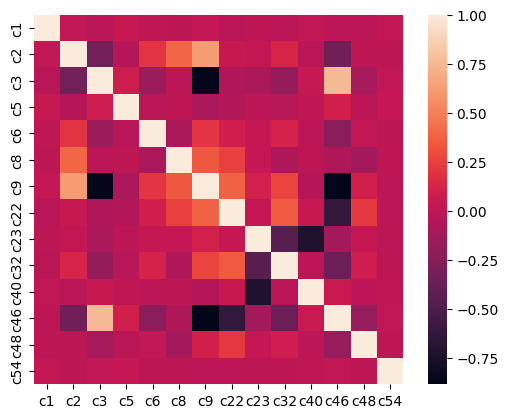

In [120]:
# обработку закончили, приступим к аналитической части. Построим тепловую карту корреляции значений разных колонок между
# собой. Чем светлее квадрат - тем больше корреляция между колонками
import seaborn as sns
cor = df.corr()
sns.heatmap(cor, square = True)
df_inf = df

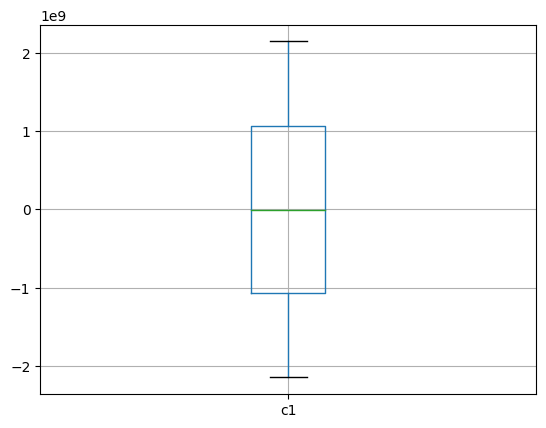

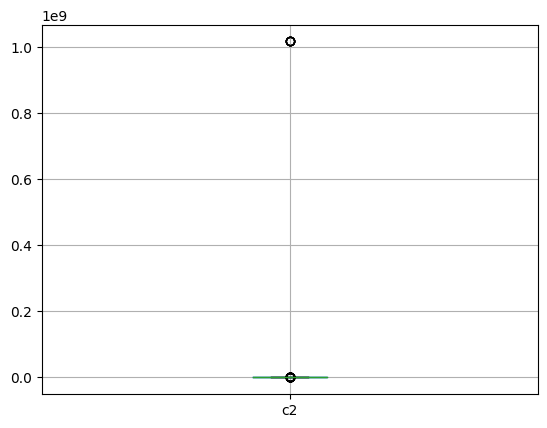

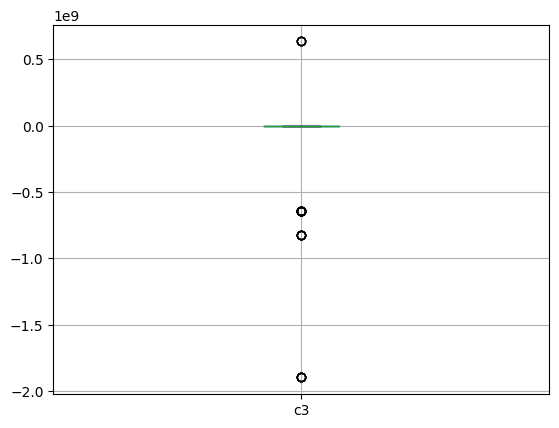

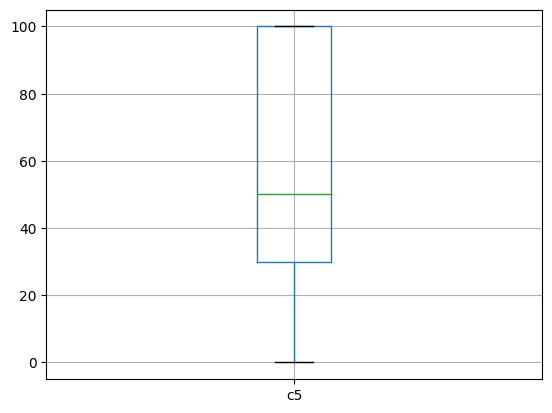

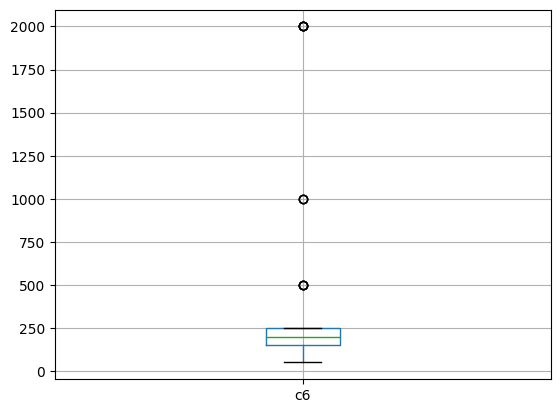

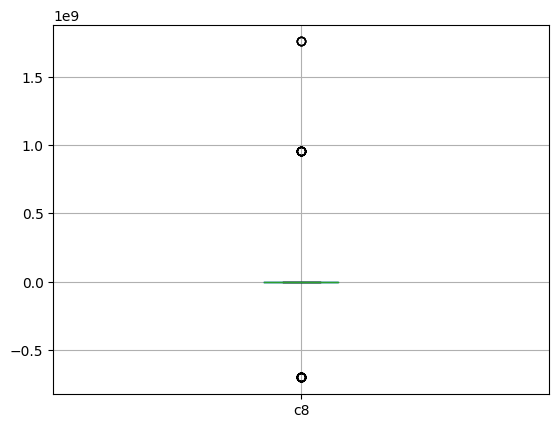

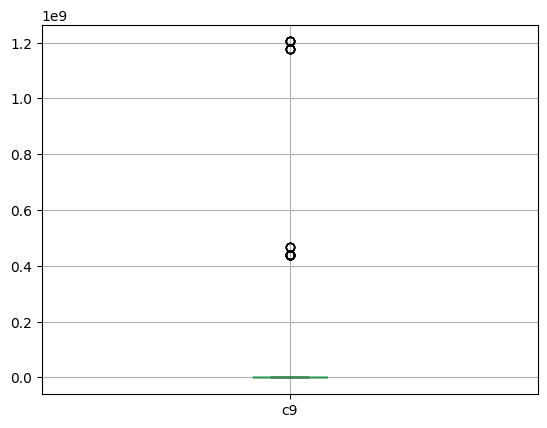

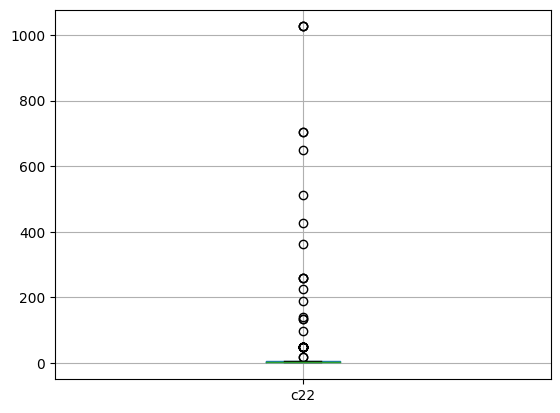

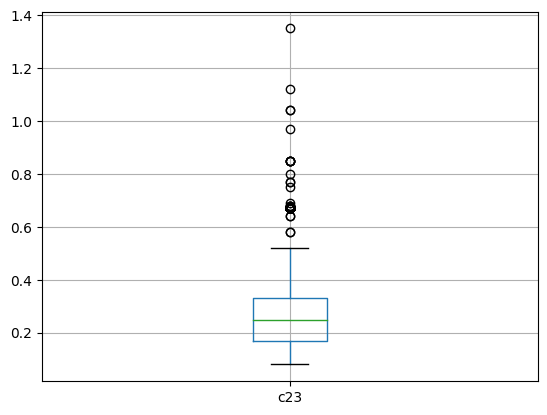

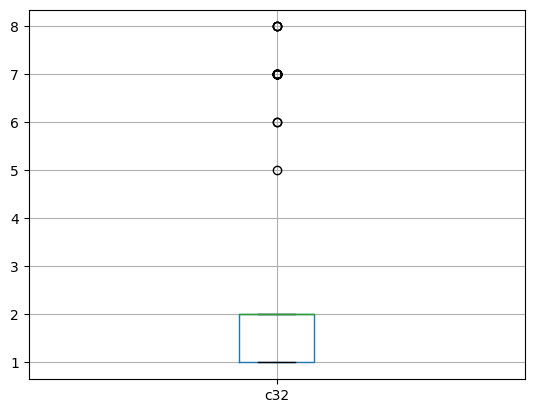

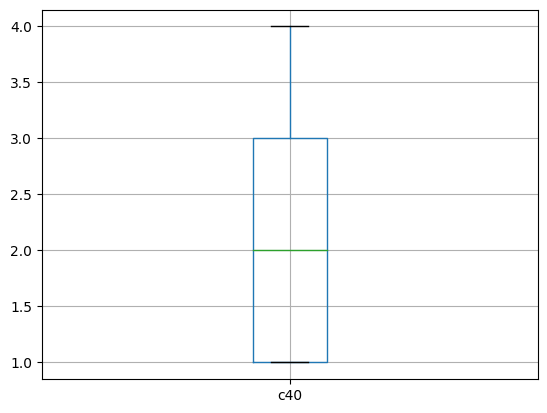

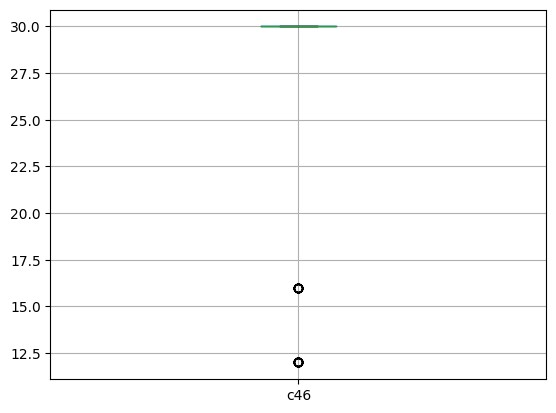

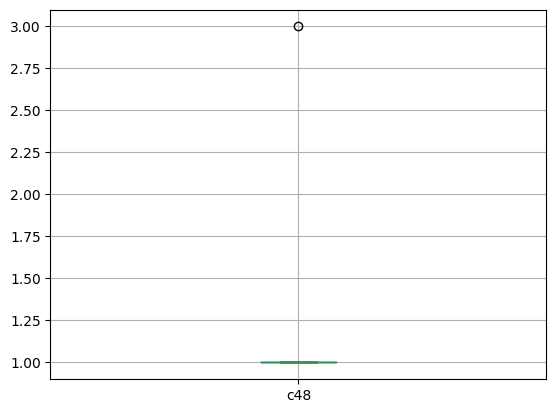

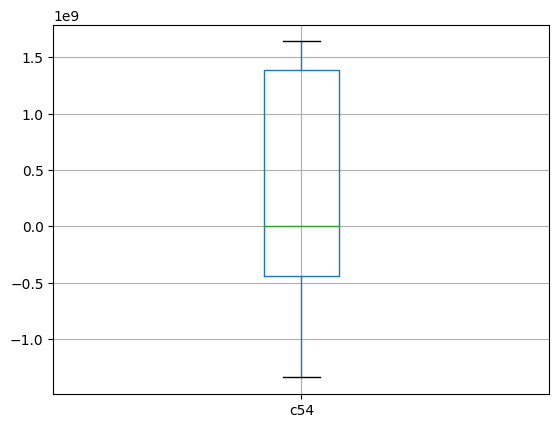

In [121]:
import matplotlib.pyplot as plt

for column in df:
    plt.figure()
    df.boxplot([column])

In [122]:
#убираем выбросы из всех колонок по 0.99 квантилю
for column in df_inf:
  limiter = df_inf[column].quantile(0.99)
  df_inf = df_inf[df_inf[column]<=limiter]

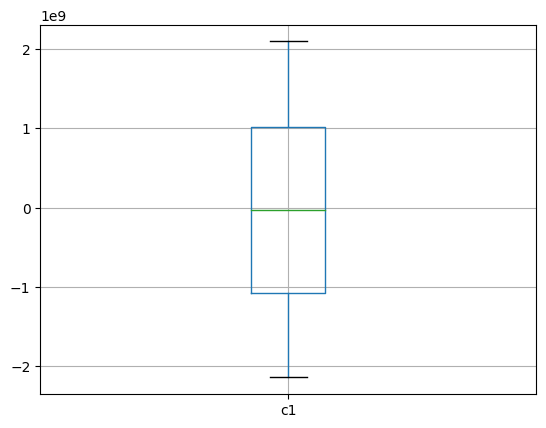

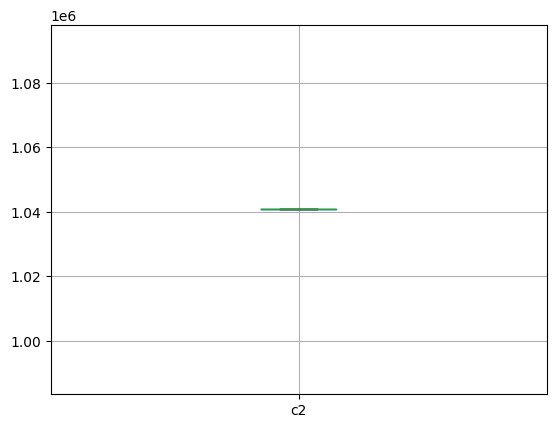

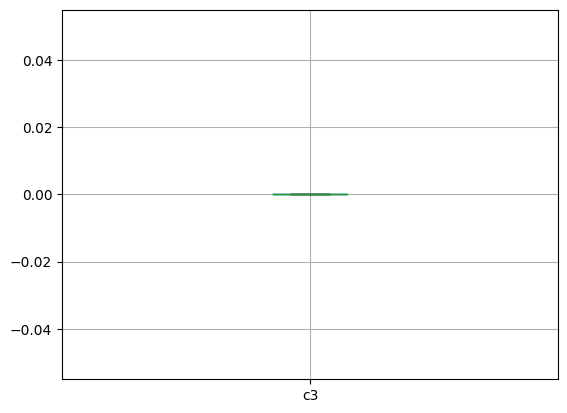

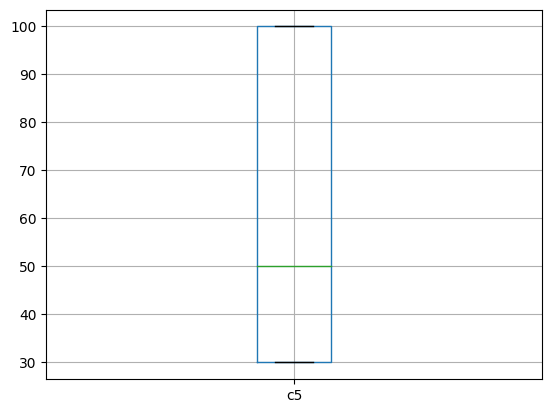

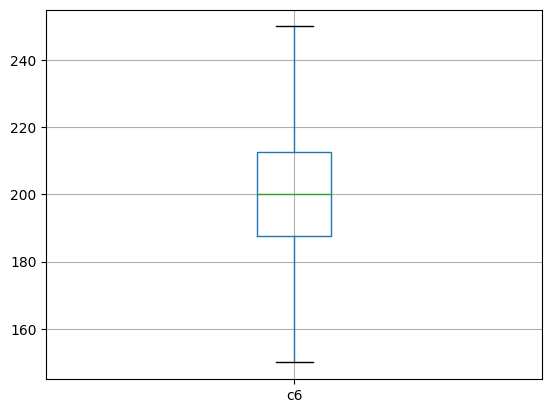

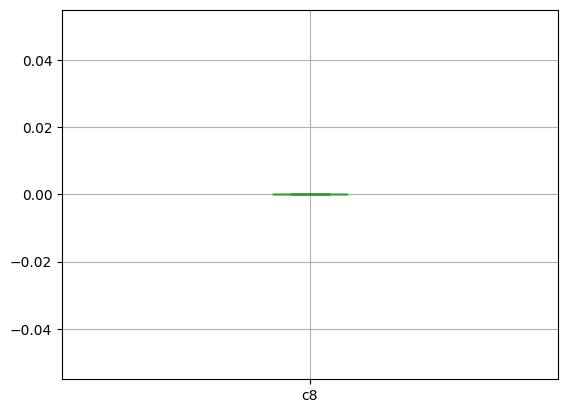

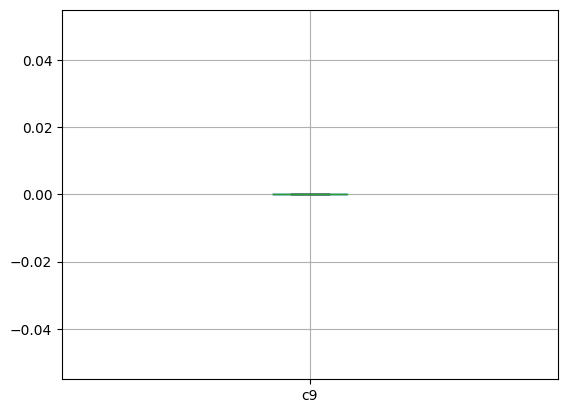

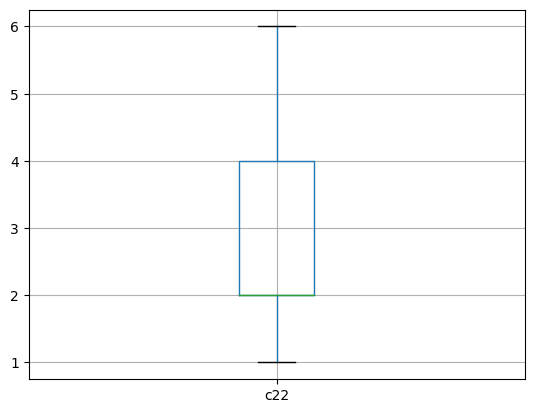

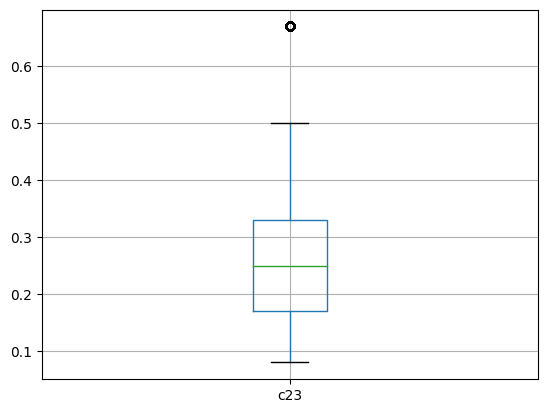

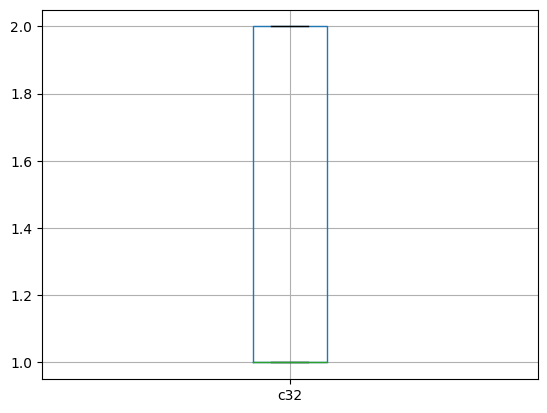

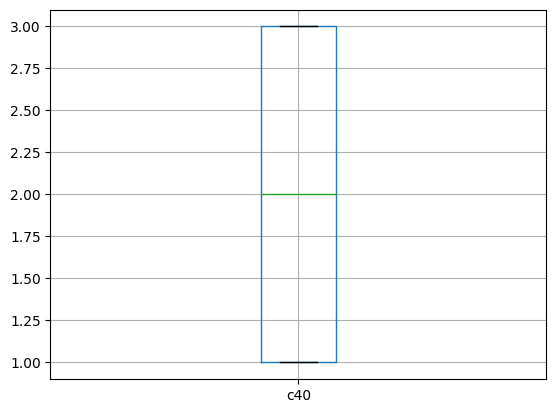

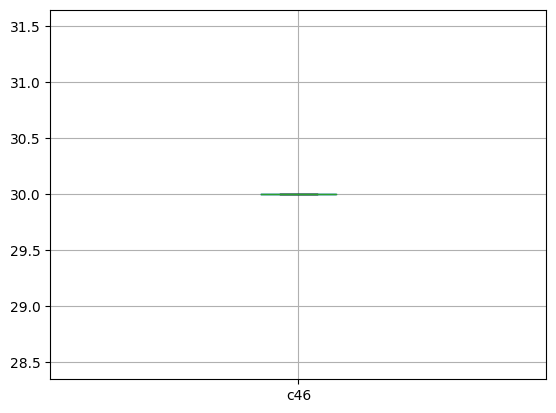

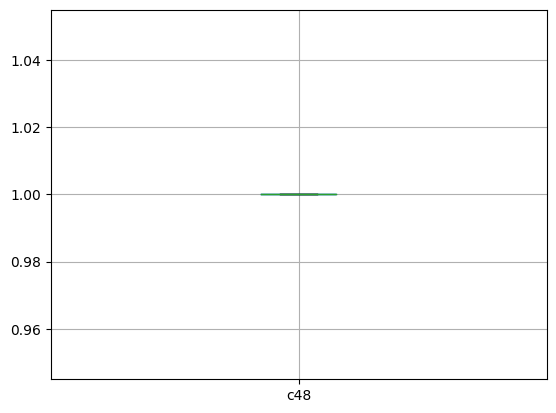

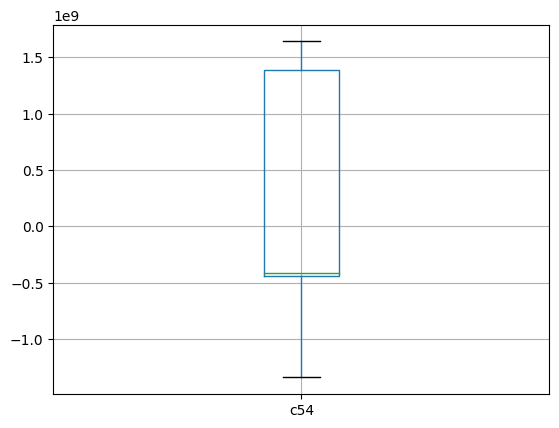

In [123]:
for column in df_inf:
    plt.figure()
    df_inf.boxplot([column])

In [131]:
df_inf['c48'].value_counts()

1.0    15212
Name: c48, dtype: int64

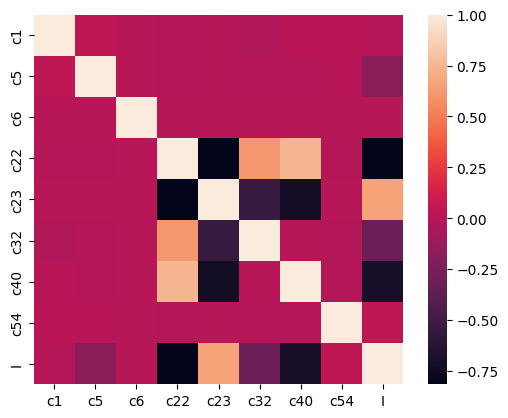

In [143]:
df = df_inf.drop(['c2', 'c3', 'c8', 'c9', 'c46', 'c48'], axis=1)
cor = df.corr()
sns.heatmap(cor, square = True)
df_inf = df

In [133]:
# займёмся препроцесингом данных для лучшего применения алгоритма на них. Отмасштабируем и нормализуем данные.
# все данные будут иметь среднее значение в районе нуля, а отклонение от -1 до 1. Так проще алгоритму.
from sklearn.preprocessing import StandardScaler, normalize
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df)

In [134]:
X_normalized = normalize(X_scaled)

In [135]:
# данные после препроцессинга
df = pd.DataFrame(X_normalized)
df

,0,1,2,3,4,5,6,7
0,-0.143260,-0.343047,0.463102,-0.399502,0.461636,-0.326689,-0.399981,-0.088944
1,-0.026920,-0.338399,0.456827,-0.394089,0.455381,-0.322262,-0.394561,0.232081
2,-0.028252,-0.157237,0.479430,-0.413587,0.477912,-0.338207,-0.414082,0.243564
3,-0.306289,-0.322844,0.435829,-0.375974,0.434449,-0.307449,-0.376424,-0.213751
4,-0.306289,-0.322844,0.435829,-0.375974,0.434449,-0.307449,-0.376424,-0.213751
...,...,...,...,...,...,...,...,...
15207,0.026772,0.310201,-0.440615,0.571531,-0.298912,0.312300,0.381159,0.223845
15208,0.372286,0.320856,0.000000,0.591163,-0.309179,0.323028,0.394252,0.231534
15209,0.029823,0.345552,0.000000,0.636665,-0.332977,0.347891,0.424597,0.249355
15210,0.372286,0.320856,0.000000,0.591163,-0.309179,0.323028,0.394252,0.231534


<AxesSubplot: >

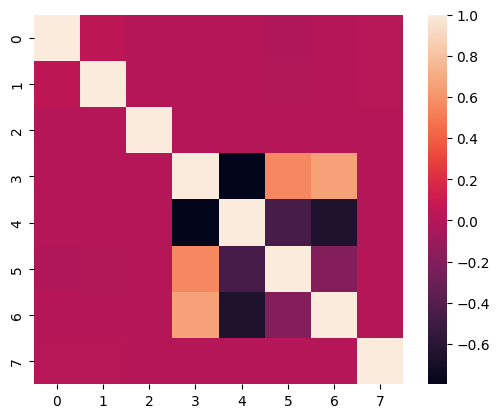

In [136]:
# на каком-то этапе решил ещё раз построить хитмап, чтобы убедится, что в основном корреляция осталась прежней.
cor = df.corr()
sns.heatmap(cor, square = True)

In [ ]:
Дальше идут тесты параметров, примерно на 10 окон.

In [60]:
pdist_metrics = ['braycurtis', 'canberra', 'chebyshev', 'cityblock', 'correlation', 'cosine', 'dice', 'euclidean', 'hamming', 'jaccard', 'jensenshannon', 'kulczynski1', 'mahalanobis', 'matching', 'minkowski', 'rogerstanimoto', 'russellrao', 'seuclidean', 'sokalmichener', 'sokalsneath', 'sqeuclidean', 'yule']

In [50]:
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import *
from sklearn.metrics import silhouette_score

In [62]:
sil_scores = []
for i in pdist_metrics:
    data_dist = pdist(df, metric=i)
    data_linkage = linkage(data_dist, method='ward')
    nClust = 3
    clusters=fcluster(data_linkage, nClust, criterion='maxclust')
    print(i, silhouette_score(df, clusters, metric=i), sep=': ')
    


braycurtis: 0.3645725374853735
canberra: 0.26179733350468865
chebyshev: 0.10815456961638438
cityblock: 0.26147736974124486
correlation: 0.31019677121786404
cosine: 0.3017726843901456


ValueError: Number of labels is 1. Valid values are 2 to n_samples - 1 (inclusive)

In [64]:
pdist_metr = ['euclidean', 'hamming', 'jaccard', 'jensenshannon', 'kulczynski1', 'mahalanobis', 'matching', 'minkowski', 'rogerstanimoto', 'russellrao', 'seuclidean', 'sokalmichener', 'sokalsneath', 'sqeuclidean', 'yule']

for i in pdist_metr:
    try:
        data_dist = pdist(df, metric=i)
        data_linkage = linkage(data_dist, method='ward')
        nClust = 3
        clusters=fcluster(data_linkage, nClust, criterion='maxclust')
        print(i, silhouette_score(df, clusters, metric=i), sep=': ')
    except:
        print(i, 'error')

euclidean: 0.18315156917453768
hamming: 0.0009086350226401303


C:\Users\Uldum\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\pairwise.py:2025: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\Uldum\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\pairwise.py:2025: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)


jaccard: 0.0
jensenshannon error
kulczynski1 error
mahalanobis error


C:\Users\Uldum\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\pairwise.py:2025: DataConversionWarning: Data was converted to boolean for metric matching
  warnings.warn(msg, DataConversionWarning)
C:\Users\Uldum\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\pairwise.py:2025: DataConversionWarning: Data was converted to boolean for metric matching
  warnings.warn(msg, DataConversionWarning)


matching: 0.0
minkowski: 0.18315156917453762
rogerstanimoto error
russellrao error
seuclidean: 0.924313864652663
sokalmichener error
sokalsneath error
sqeuclidean: 0.3017726843901455
yule error


In [65]:
dist_metric = 'seuclidean'
nClust = 3
f_cl_criterion='maxclust'
link_meths = ['single', 'complete', 'average', 'weighted', 'centroid', 'median', 'ward']


for i in link_meths:
    try:
        data_dist = pdist(df, metric=dist_metric)
        data_linkage = linkage(data_dist, method=i)
        nClust = nClust
        clusters=fcluster(data_linkage, nClust, criterion=f_cl_criterion)
        print(i, silhouette_score(df, clusters, metric=dist_metric), sep=': ')
    except:
        print(i, 'error')

single: 0.9511646515576618
complete: 0.9511646515576618
average: 0.9511646515576618
weighted: 0.9511646515576618
centroid: 0.9511646515576618
median: 0.9511646515576618
ward: 0.924313864652663


In [138]:
dist_metric = 'euclidean'
link_meth = 'ward'
nClusts = [3, 4, 5, 6, 7, 10, 12, 14, 20, 30, 40, 50, 100, 200]
f_cl_criterion='maxclust'


for i in nClusts:
    try:
        data_dist = pdist(df, metric=dist_metric)
        data_linkage = linkage(data_dist, method=link_meth)
        clusters=fcluster(data_linkage, i, criterion=f_cl_criterion)
        print(i, silhouette_score(df, clusters, metric=dist_metric), sep=': ')
    except:
        print(i, 'error')

3: 0.21916325411972878
4: 0.2105168033302492
5: 0.23449530911133137
6: 0.22512508065061856
7: 0.22840637484772167
10: 0.22602794853012487
12: 0.2310037596513947
14: 0.22131538477139837
20: 0.23622948219591283
30: 0.2549615697862649
40: 0.27282048737152925
50: 0.29270755717443436
100: 0.3988270999186293
200: 0.4419082864649875


In [67]:
dist_metric = 'seuclidean'
link_meth = 'average'
nClusts = 3
f_cl_criterions=['maxclust', 'inconsistent', 'distance', 'monocrit', 'maxclust_monocrit']


for i in f_cl_criterions:
    try:
        data_dist = pdist(df, metric=dist_metric)
        data_linkage = linkage(data_dist, method=link_meth)
        clusters=fcluster(data_linkage, nClusts, criterion=i)
        print(i, silhouette_score(df, clusters, metric=dist_metric), sep=': ')
    except:
        print(i, 'error')

maxclust: 0.9511646515576618
inconsistent error
distance: 0.22982593196725296
monocrit error
maxclust_monocrit error


In [139]:
#выше - тесты 9перебор) разных параметров. Желательно делать перекрёстные (вложенные циклы списков параметров),но
# это долго на данном ПК. Можно попробовать на серверных мощностях
#ниже - кластеризация на 100 кластеров и 
# расчёт силуэта. Можно менять число кластеров, будет меняться силуэт. 

from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import *
from sklearn.metrics import silhouette_score

dist_metric = 'euclidean'
link_meth = 'ward'
nClusts = 100
f_cl_criterion='maxclust'

data_dist = pdist(df, metric=dist_metric)
data_linkage = linkage(data_dist, method=link_meth)
clusters=fcluster(data_linkage, nClusts, criterion=f_cl_criterion)
print(silhouette_score(df, clusters, metric=dist_metric))

0.3988270999186293


In [144]:
# закидываем колонку с номером кластера каждой строки и группируем по этой колонке с целью найти значения сэмплов в 
# каждом кластере. Нужно, чтобы отсеять кластеры с незначительным числом сэмплов - это выбросы, шум.
df_inf['I']=clusters
res=df_inf.groupby('I')[list(df_inf.columns)].mean()
res['Количество']=df_inf.groupby('I').size().values
res.sort_values('Количество', axis=0, ascending=False, inplace=False, kind='quicksort', na_position='last', ignore_index=False, key=None).tail(20)

,c1,c5,c6,c22,c23,c32,c40,c54,I,Количество
I,,,,,,,,,,
69,-8.027987e+08,35.600000,250.000000,2.000000,0.290800,1.0,2.000000,1.344639e+09,69.0,100
64,1.340630e+09,32.828283,250.000000,2.555556,0.239192,1.0,2.555556,1.429181e+09,64.0,99
34,-1.269433e+09,100.000000,183.333333,3.000000,0.194242,1.0,3.000000,1.412926e+09,34.0,99
66,1.340630e+09,32.828283,150.000000,2.555556,0.239192,1.0,2.555556,1.429181e+09,66.0,99
90,7.109940e+08,35.360825,150.000000,2.000000,0.286289,2.0,1.000000,1.354243e+09,90.0,97
16,-8.180887e+08,33.956044,150.000000,4.000000,0.148901,2.0,2.000000,1.393034e+09,16.0,91
29,-8.180887e+08,33.956044,250.000000,4.000000,0.148901,2.0,2.000000,1.393034e+09,29.0,91
57,8.653248e+08,30.000000,250.000000,2.000000,0.290000,1.0,2.000000,-7.134612e+08,57.0,90
38,1.113649e+09,100.000000,150.000000,2.000000,0.282889,1.0,2.000000,1.416083e+09,38.0,90


In [145]:
# убираем кластеры с числом сэмплов менее 40
clust_list = list(res.loc[res['Количество'] > 40]['I'])

In [148]:
df_it_1 = df_inf.loc[df_inf['I'].isin(clust_list)]
df_it_1

,c1,c5,c6,c22,c23,c32,c40,c54,I
43,-578661768,30,250.0,1.0,0.50,1.0,1.0,0,74
44,-141440989,30,250.0,1.0,0.50,1.0,1.0,1034116331,78
45,-141440989,50,250.0,1.0,0.50,1.0,1.0,1034116331,78
46,-1265566495,30,250.0,1.0,0.50,1.0,1.0,-440751703,74
47,-1265566495,30,250.0,1.0,0.50,1.0,1.0,-440751703,74
...,...,...,...,...,...,...,...,...,...
15398,67530697,100,150.0,6.0,0.11,2.0,3.0,1034116331,7
15399,1387651697,100,200.0,6.0,0.11,2.0,3.0,1034116331,7
15400,67530697,100,200.0,6.0,0.11,2.0,3.0,1034116331,7
15401,1387651697,100,200.0,6.0,0.11,2.0,3.0,1034116331,7


In [147]:
#эта строка для будущей проверки. Набор параметров-фильтров какого-то кабеля, чтобы открылись следующие фильтры
# с1 = 1884968178  c5 = 100  c6 = 250  c32 = 2.0 c54 = -718884441
df_it_1.loc[df_it_1['I']==1]

,c1,c5,c6,c22,c23,c32,c40,c54,I
13150,1108441822,100,250.0,6.0,0.08,2.0,3.0,-440751703,1
13151,1108441822,100,250.0,6.0,0.08,2.0,3.0,-440751703,1
13166,1612523589,100,250.0,6.0,0.08,2.0,3.0,0,1
13171,1884968178,100,250.0,6.0,0.08,2.0,3.0,-718884441,1
13172,1884968178,100,250.0,6.0,0.08,2.0,3.0,-718884441,1
...,...,...,...,...,...,...,...,...,...
15315,1735119445,100,200.0,6.0,0.11,2.0,3.0,-1339337773,1
15329,1219700153,100,200.0,6.0,0.11,2.0,3.0,-416966437,1
15330,1219700153,100,200.0,6.0,0.11,2.0,3.0,-416966437,1
15331,1735104434,100,200.0,6.0,0.11,2.0,3.0,-440751840,1


In [179]:
# строка для будущего запроса - взять флюбые фичи из кластера, как бы поступил пользователь

df_it_1.loc[df_it_1['I']==97]

,c1,c5,c6,c22,c23,c32,c40,c54,I
2907,341789811,100,250.0,2.0,0.25,2.0,1.0,0,97
2910,428383452,100,250.0,2.0,0.25,2.0,1.0,-440751703,97
2911,428383452,100,250.0,2.0,0.25,2.0,1.0,-440751703,97
2912,212031014,100,250.0,2.0,0.25,2.0,1.0,-718884441,97
2913,212031014,100,250.0,2.0,0.25,2.0,1.0,-718884441,97
...,...,...,...,...,...,...,...,...,...
4976,-1795403465,100,250.0,2.0,0.33,2.0,1.0,-416966437,97
4977,-1279999184,100,250.0,2.0,0.33,2.0,1.0,-440751840,97
4978,-1279999184,100,250.0,2.0,0.33,2.0,1.0,-440751840,97
4979,-766007325,100,250.0,2.0,0.33,2.0,1.0,-1339337773,97


In [150]:
# строка для будущего запроса - взять флюбые фичи из кластера, как бы поступил пользователь

df_it_1.loc[df_it_1['I']==99]

,c1,c5,c6,c22,c23,c32,c40,c54,I
2945,341789811,100,150.0,2.0,0.25,2.0,1.0,0,99
2948,428383452,100,150.0,2.0,0.25,2.0,1.0,-440751703,99
2949,428383452,100,150.0,2.0,0.25,2.0,1.0,-440751703,99
2950,212031014,100,150.0,2.0,0.25,2.0,1.0,-718884441,99
2951,212031014,100,150.0,2.0,0.25,2.0,1.0,-718884441,99
...,...,...,...,...,...,...,...,...,...
5008,-560164423,100,150.0,2.0,0.33,2.0,1.0,-440751703,99
5009,1100327811,100,150.0,2.0,0.33,2.0,1.0,-718884441,99
5010,1100327811,100,150.0,2.0,0.33,2.0,1.0,-718884441,99
5017,-766007325,100,150.0,2.0,0.33,2.0,1.0,-1339337773,99


<AxesSubplot: >

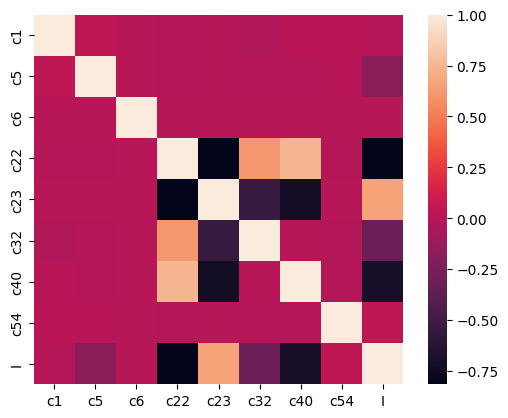

In [151]:
cor = df_it_1.corr()
sns.heatmap(cor, square = True)

In [164]:
df_it_2 = df_it_1

In [165]:
#Далее нужно определить значимые фичи каждого кластера. Для этого обучим модель классификации. Можно взять любую, которая
#поддерживает мультиклассовость и мульлэйбелинг (много классов и много признаков). Список есть в документации sklearn для
#мультиклассовой классификации

#нормализуем данные перед обучением, выведем теплокарту корреляций

from sklearn.ensemble import ExtraTreesClassifier

In [180]:
# импортируем, делим данные на признаки и целевую колонку, нормализуем признаки Х
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
X = df_it_2.drop(['I'], axis = 1) 
y = df_it_2.I         
X=(X-X.min())/(X.max()-X.min())
y  

43       74
44       78
45       78
46       74
47       74
         ..
15398     7
15399     7
15400     7
15401     7
15402     7
Name: I, Length: 15212, dtype: int32

In [181]:
X

,c1,c5,c6,c22,c23,c32,c40,c54
43,-578661768,30,250.0,1.0,0.50,1.0,1.0,0
44,-141440989,30,250.0,1.0,0.50,1.0,1.0,1034116331
45,-141440989,50,250.0,1.0,0.50,1.0,1.0,1034116331
46,-1265566495,30,250.0,1.0,0.50,1.0,1.0,-440751703
47,-1265566495,30,250.0,1.0,0.50,1.0,1.0,-440751703
...,...,...,...,...,...,...,...,...
15398,67530697,100,150.0,6.0,0.11,2.0,3.0,1034116331
15399,1387651697,100,200.0,6.0,0.11,2.0,3.0,1034116331
15400,67530697,100,200.0,6.0,0.11,2.0,3.0,1034116331
15401,1387651697,100,200.0,6.0,0.11,2.0,3.0,1034116331


In [161]:
# по-хорошему тут надо сплитить данные на проверочные и тестовые, подбирать модели и с помощью тестовых определять лучшую,
# но в этот раз мы не будем заниматься мультимоделирвоанием, поэтому данные можно не делить
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=17)

In [182]:
#фитим данные в модель, обучаем. Зафитил все данные, без тестовых, так как никаких показателей качества искать сейчас
#нет смысла
extc = ExtraTreesClassifier(n_estimators=100,max_features= 168,criterion= 'entropy',min_samples_split= 3,
                            max_depth= 30, min_samples_leaf= 8)      
extc.fit(X,y)

ExtraTreesClassifier(criterion='entropy', max_depth=30, max_features=168,
                     min_samples_leaf=8, min_samples_split=3)

<AxesSubplot: >

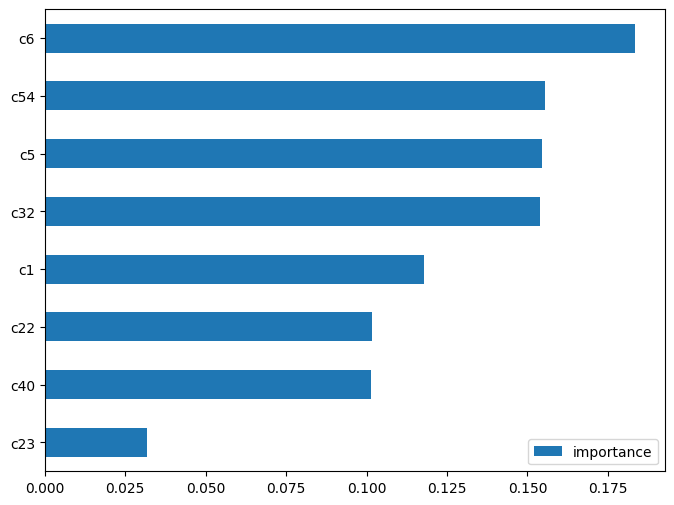

In [183]:
# выводим вес признаков (коэффициенты при признаках)
imp = pd.DataFrame(extc.feature_importances_, index=X.columns, columns=['importance'])
imp.sort_values('importance').plot(kind='barh', figsize=(8, 6))

In [184]:
# веса в табличном виде. Видим 4 явных фаворита. Отберём их и на их основе обучим модель для предсказания кластера,
# в котором будет находится товар, который хочет кастомер (c1, с6, с54, с5, с32) 
# Эти 5 фильтров покупатель увидит первыми

feature_importances_df = pd.DataFrame({'features': list(X), 'feature_importances': extc.feature_importances_})
fi_df_sort = feature_importances_df.sort_values('feature_importances', ascending = False)
fi_df_sort

,features,feature_importances
2,c6,0.183528
7,c54,0.155438
1,c5,0.154542
5,c32,0.153910
0,c1,0.117780
3,c22,0.101629
6,c40,0.101370
4,c23,0.031803


In [136]:
# 2 строки просто показать, что результат предсказания модели - это лишь вероятность. То есть данные теряются после каждого
# предикта
prediction_of_probability = extc.predict_proba(X_test)

In [143]:
pd.DataFrame(prediction_of_probability).tail()

,0,1,2,3,4,5,6,7,8,9,...,71,72,73,74,75,76,77,78,79,80
1531,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
1532,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.003333,0.996667,0.0,0.0,0.0,0.0,0.0
1533,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
1534,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
1535,0.0,0.992857,0.0,0.0,0.0,0.0,0.0,0.0,0.007143,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0


In [190]:
# тут я готовлю данные для обучения второй модели без лишних признаков (которые не вошли в топ на прошлом шаге)
# дропаем эти колонки, делим данные, нормализуем
X = df_it_2.drop(['I', 'c40', 'c23', 'c22'], axis = 1) 
y = df_it_2.I         
X=(X-X.min())/(X.max()-X.min())
y 

43       74
44       78
45       78
46       74
47       74
         ..
15398     7
15399     7
15400     7
15401     7
15402     7
Name: I, Length: 15212, dtype: int32

In [191]:
X

,c1,c5,c6,c32,c54
43,0.368848,0.000000,1.0,0.0,0.449663
44,0.471925,0.000000,1.0,0.0,0.796853
45,0.471925,0.285714,1.0,0.0,0.796853
46,0.206907,0.000000,1.0,0.0,0.301687
47,0.206907,0.000000,1.0,0.0,0.301687
...,...,...,...,...,...
15398,0.521192,1.000000,0.0,1.0,0.796853
15399,0.832418,1.000000,0.5,1.0,0.796853
15400,0.521192,1.000000,0.5,1.0,0.796853
15401,0.832418,1.000000,0.5,1.0,0.796853


In [193]:
# делим данные, но обучать будем на всех. Эта строка, просто чтобы помнить, как надо делать
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=15)

In [192]:
# фитим/обучаем
extc2 = ExtraTreesClassifier(n_estimators=100,max_features= 168,criterion= 'entropy',min_samples_split= 3,
                            max_depth= 30, min_samples_leaf= 8)      
extc2.fit(X,y)

ExtraTreesClassifier(criterion='entropy', max_depth=30, max_features=168,
                     min_samples_leaf=8, min_samples_split=3)

In [193]:
# Тут надо остановиться. У нас есть вторая обученная модель, которая после ввода кастомером фильтров предскажет к какому
# кластеру она относится, чтобы он смог перейти к фильтрам уже конкретного кластера
# Сейчас я вытащу данные по 4 отобранным фильтрам из таблицы выше, имитируя пользователя, зафичу их в модель и 
# предскажу кластер, в который ему надо попасть
#Features from cluster N1: с1 = 1884968178  c5 = 100  c6 = 250  c32 = 2.0 c54 = -718884441

cust_dict = {'c1':[1884968178],'c5':[100], 'c6':[250.0], 'c32':[2.0], 'c54':[-718884441]}
cust_req = pd.DataFrame.from_dict(cust_dict)

In [194]:
# Тут надо нормализовать запрос пользователя. Как я делаю это обычно не получится, точнее получится, но с бубном, потому
# что у датафрейма-запроса пользователя нет минимума. Так всего 1 строка. Значит надо взять минимум из датафрейма, 
# на котором мы обучали последнюю модель и сделать такую же нормализацию.

X_min_max = df_it_2.drop(['I', 'c40', 'c23', 'c22'], axis = 1) 
cust_req_X = (cust_req-X_min_max.min())/(X_min_max.max()-X_min_max.min())
cust_req_X

,c1,c5,c6,c32,c54
0,0.949663,1.0,1.0,1.0,0.208308


In [195]:
# фитим в модель запрос покупателя, получаем номер кластера
extc2.predict(cust_req_X)

array([1], dtype=int32)

In [199]:
#кластер был выбран по 5 фильтрам, сократив число позиций с 15000 до 159
#дальше вторая итерация: разбиение кластера на подкластеры, обучение модели, выделение значимых признаков через
#оценку весов и выведение этих признаков в качестве фильтров.
#!!!ВАЖНО!!! убрать признаки из прошлой итерации, а также столбца I

df_it_3 = df_it_1.loc[df_it_1['I']==1].drop(['I', 'c1', 'c5', 'c6', 'c32', 'c54'], axis = 1)
df_it_3

,c22,c23,c40
13150,6.0,0.08,3.0
13151,6.0,0.08,3.0
13166,6.0,0.08,3.0
13171,6.0,0.08,3.0
13172,6.0,0.08,3.0
...,...,...,...
15315,6.0,0.11,3.0
15329,6.0,0.11,3.0
15330,6.0,0.11,3.0
15331,6.0,0.11,3.0


In [ ]:
С каждым шагом мы снижаем кол-во фильтров, выдаём пользователю наиболее весомые признаки, снижаем число сэмплов по данным. 
Когда число строк в кластере достигнет нужного количества - пользователь найдёт товар.
Если число фильтров превысит максимум, а товар не будет найден, то целесообразно использовать заполненные фильтры для
поиска по всей БД SQL-запросом, а не только по выделенному кластеру.

Проблема в том, что пользователь должен заполнить все выданные фильтры. Иначе модель не сможет предсказать кластер, потому
что ей вернутся неполняе данные. Либо модель придётся переобучать с учётом незаполненных фильтров, либо выдавать следующие 
по весу фильтры, вместо незаполненных и также переобучать модель.

Вообще, можно просто определять значимые фильтры по этой методике на данных. Допустим на всех данных (вся БД) мы вявили
приоритет признаков, которые можем выдаваь пользователю. После определённого кол-ва фильтров, кол-во данных снизится
и можно будет пересчитать веса признаков-фильтров уже для меньшего кол-ва данных. И также выдавать их пользователю по
приоритету большего веса.

Допустим, сейчас у нас осалось 3 фильтра и сет из 159 строк. Можно обучить модель на этом сете, определить веса признаков
и выдать 1 наиболее весомый. Давайте сделаем. По данным и так всё понятно, логично. Но не будем смотреть в данные.

In [206]:
# разобьём на кластеры. Вообще, методику подбора числа кластеров надо ещё обдумать.

dist_metric = 'euclidean'
link_meth = 'ward'
nClusts = 3
f_cl_criterion='maxclust'

data_dist = pdist(df_it_3, metric=dist_metric)
data_linkage = linkage(data_dist, method=link_meth)
clusters=fcluster(data_linkage, nClusts, criterion=f_cl_criterion)
print(silhouette_score(df_it_3, clusters, metric=dist_metric))

1.0


In [207]:
# забавно получилось. Данных уже мало на этой итерации и алгоритм не может разбить одинакоые данные на более чем 2 кластера
# ничего страшного, обучим модель на этом.

df_it_3['I']=clusters
res=df_it_3.groupby('I')[list(df_it_3.columns)].mean()
res['Количество']=df_it_3.groupby('I').size().values
res.sort_values('Количество', axis=0, ascending=False, inplace=False, kind='quicksort', na_position='last', ignore_index=False, key=None).tail(20)

,c22,c23,c40,I,Количество
I,,,,,
1,6.0,0.08,3.0,1.0,81
2,6.0,0.11,3.0,2.0,78


In [213]:
# разделим данные на признаки и целевую колонку. Не будем нормализовывать.
X = df_it_3.drop(['I'], axis = 1) 
y = df_it_3.I         
y 

13150    1
13151    1
13166    1
13171    1
13172    1
        ..
15315    2
15329    2
15330    2
15331    2
15332    2
Name: I, Length: 159, dtype: int32

In [215]:
# применим простой агоритм дерева решений, обучим

from sklearn.tree import DecisionTreeClassifier

clf_gini = DecisionTreeClassifier(criterion='gini', max_depth=3, random_state=7)
clf_gini.fit(X, y)

DecisionTreeClassifier(max_depth=3, random_state=7)

<AxesSubplot: >

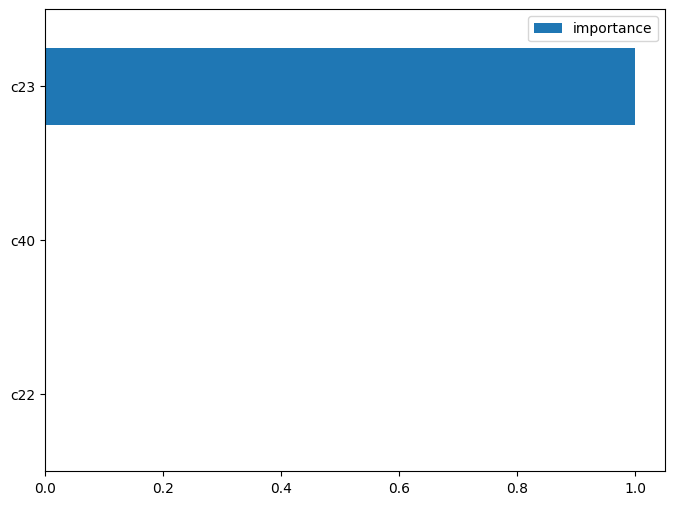

In [216]:
#выведем важность признаков-фильтров

imp = pd.DataFrame(clf_gini.feature_importances_, index=X.columns, columns=['importance'])
imp.sort_values('importance').plot(kind='barh', figsize=(8, 6))

In [ ]:
Понятно почему только 1 признак забирает весь вес. Осталось мало данных и отличие только в признаке с23. 
Осталось бы больше меняющихся признаков - картина была бы другой. И, по сути, покупатель 
нашёл свой товар из 15000 за 6 фильтров.
Если товаров будут десятки миллионов, то последовательность особо не изменится. Станет тяжелее работать с данными,
дольше обучать модели для определения весов. Но, для первичных фильров можно сделать предобучение и заранее найти веса-
приоритеты фильтров, разбив БД на 20-30 кластеров. Далее, для каждого из этих 20-30 кластеров проделать такую же работу.
И определить приоритеты фильров для попадания в подкластеры. Можно придумать что-то ещё...